### Tuning the LSTM model ... 

File copied from "REAL" model tuning for EOF on 8/4/2025.  

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

#tf.compat.v1.disable_eager_execution()
#import investigate

import keras_tuner as kt

2025-08-04 17:42:28.437491: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 17:42:28.439490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-04 17:42:28.466085: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-04 17:42:28.466106: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-04 17:42:28.466124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
print(tf.__version__)

2.14.1


In [3]:
#load input data, it is max/min standardized, NaNs removed
#stratospheric polar vortex ellipse diagnostics from Fernandez et al 2025 (in review)
#comparison here may be a little muddled because I am limitied in the days that I can observe, however, I am currently working(7/8/2025) on calculating the diagnostics for the full dataset
#this will be fixed. 

infile = open("../data/nolag_extendedanom_input.p", 'rb') 
nolag_input = pickle.load(infile)
infile.close()

nolag_input.shape

(62, 149, 8)

In [4]:
idx = 149
#switch to 149 for normal. 

inp1 = np.empty((62,idx,8)) #create new input array, 14 day lag. 

shift = 0
#0 if normal
#this indicates setting the start date as November 2 rather than October 19

##reshaping to change lag in metrics for input
inp1[:,:,0] = nolag_input[:62,shift:,0] ##wind
inp1[:,:,1] = nolag_input[:62,shift:,1] ##ratio
inp1[:,:,2] = nolag_input[:62,shift:,2] ##latitude
inp1[:,:,3] = nolag_input[:62,shift:,3] ##longitude
inp1[:,:,4] = nolag_input[:62,shift:,4] ##size
inp1[:,:,5] = nolag_input[:62,shift:,5] ##ephi
inp1[:,:,6] = nolag_input[:62,shift:,6] ##gph
inp1[:,:,7] = nolag_input[:62,shift:,7] ##pv

inp=inp1.reshape(62*idx,8)
inp.shape

(9238, 8)

In [5]:
#load output data file.
#I can change this to represent any of the available temp regions. 
infile = open("../data/eur_anomtemps_reduced.p","rb",)
output = pickle.load(infile) 
infile.close()

In [6]:
output.shape

(9238,)

In [9]:
#convert to pandas dataframe
input = pd.DataFrame(inp)
#label columns of variables for input data
col_names = ['wind','rat','cenlat','cenlon','size','ephi','gph','pv']
input.columns = col_names

input##make pandas dataframe for RF
input = pd.DataFrame(input)
input

,wind,rat,cenlat,cenlon,size,ephi,gph,pv
0,0.570790,0.618161,0.828871,0.055095,0.326356,0.726418,0.719386,0.126977
1,0.573147,0.626809,0.826273,0.565595,0.330771,0.733839,0.721613,0.203389
2,0.576683,0.629552,0.822728,0.707387,0.341216,0.734021,0.727079,0.232331
3,0.581320,0.621400,0.820200,0.769665,0.351285,0.743165,0.726248,0.218715
4,0.585344,0.615700,0.820122,0.801782,0.360734,0.757252,0.722180,0.208927
...,...,...,...,...,...,...,...,...
9233,0.593302,0.446485,0.741122,0.674863,0.550987,0.194401,0.583356,0.649220
9234,0.585727,0.443649,0.738294,0.688205,0.539156,0.203137,0.576748,0.704463
9235,0.581969,0.438761,0.736058,0.705501,0.522961,0.221439,0.577187,0.760367
9236,0.581262,0.432586,0.734603,0.725774,0.506165,0.259560,0.586223,0.765773


In [10]:
inp2 = input.values.reshape(62,149,8)
inp2.shape

(62, 149, 8)

In [11]:
##need to change this based on lag 
## 14-days = [:, 10:] 10 day window rather than 14
## 20-days = [:, 16:]
## 30-days = [:, 26:]

# 139
# 133
# 123

## 14-days = [:, 14:] 14 day window
## 20-days = [:, 20:]
## 30-days = [:, 30:]

# 135
# 129
# 119

lead = 135

temp = output.reshape(62, 149)
temp = temp[:, 14:]
print(temp.shape)

temp_flat = temp.flatten()

(62, 135)


In [12]:
#create timeseries data arrays for PCs 
#was 122 and 14 for the 14 day window. 

new_input =  np.empty((62,lead,14,8))
new_output = np.empty((62,lead))

for i in range(0,62):
    for j in range(0,lead):
        new_input[i,j,:,:] = inp2[i,j:j+14,:]
        new_output[i,j] = temp[i,j]

In [13]:
new_input = np.array(new_input)
new_output = np.array(new_output)
print(new_input.shape)
print(new_output.shape)

(62, 135, 14, 8)
(62, 135)


In [14]:
frac_ind = round((62*lead)*0.15)
frac_end = round((62*lead)-frac_ind)
frac_end

7114

In [15]:
frac_ind

1256

In [16]:
##Set X_all and Y_all datasets
X_all = np.copy(new_input.reshape((62*lead),14,8))
Y_all = np.copy(new_output.flatten())

##training data partition out
X_tri = X_all[:frac_end,:]
Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes = X_all[frac_end:,:]
Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [17]:
Y_all.shape

(8370, 2)

In [18]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [19]:
##checking to make sure shape was properly one hot encoded
Y_all.shape

(8370, 2)

In [20]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [21]:
##number of input nodes
numb_int = X_all.shape[1:]

##fraction of training data
X_validation = X_tri[0:frac_ind]
Y_validation = Y_tri[0:frac_ind]
        
X_train = X_tri[frac_ind:len(X_tri)]
Y_train = Y_tri[frac_ind:len(Y_tri)]

X_test = X_tes
Y_test = Y_tes

In [22]:
Y_train.shape

(5858, 2)

In [23]:
numb_int

(14, 8)

In [24]:
##do the class_dict weights
class_weight = class_weight_creator(Y_train)
class_weight

{0: 1.0, 1: 1.0604994}

### Model Architecture. 

In [25]:
######
batch_size = 64 #The number of samples the network sees before it backpropagates (batch size)
epochs = 30 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [26]:
def tune_LSTM(hp): 
    ##set ranges for hyperparameters
    n1 = hp.Int('n1', min_value=32, max_value=160, step=32)
    n2 = hp.Int('n2', min_value=4, max_value=32, step=4)
    n3 = hp.Int('n3', min_value=8, max_value=32, step=8)
    
    reg1 = hp.Float('reg1', min_value=0.001, max_value=0.9, step=0.01)
    reg2 = hp.Float('reg2', min_value=0.001, max_value=0.9, step=0.01)
    reg3 = hp.Float('reg3', min_value=0.001, max_value=0.9, step=0.01)
    
    
    input_tensor = Input(shape=(14, 8))
    layer1 = layers.RNN(
        layers.LSTMCell(n1, activation='tanh', use_bias=True,
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= reg1)),
        return_sequences=True)(input_tensor)
    layer2 = layers.RNN(
        layers.LSTMCell(n2, activation='tanh', use_bias=True,
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= reg2)),
                        return_sequences=False)(layer1)
    layer3 = layers.Dense(n3, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=reg3))(layer2)

    output_tensor = layers.Dense(2, activation='softmax',)(layer3)

    model = Model(input_tensor, output_tensor)
    
    lr = hp.Float('learning_rate', min_value=0.001, max_value=0.1)
    
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    #decay_rate = lr / epochs
    #momentum = 0.9

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[keras.metrics.categorical_accuracy],)
                            
    return model

In [27]:
##the LSTM layers will have EXACTLY the same regularizer

In [28]:
tf.keras.backend.clear_session()

In [29]:
###################################################

In [30]:
#intialize/setup the hyperband tuner
tuner = kt.RandomSearch(
    tune_LSTM, #model
    objective = [kt.Objective('val_loss', 'min')],#kt.Objective('loss', 'min'),kt.Objective('val_categorical_accuracy', 'max')],
    max_trials=1000, #number of iterations of tuning to run
    max_consecutive_failed_trials=3, #number of allowed failed trials
    directory = 'tuning',
    project_name='ellipse_lstm1'
)

In [31]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True,verbose=1)

In [ ]:
##actual tuning process
tuner.search(X_train, Y_train, validation_data=(X_validation, Y_validation),
             batch_size=batch_size, epochs=epochs, shuffle=shuffle,
             class_weight = class_weight, callbacks=[stop_early])

Trial 189 Complete [00h 00m 17s]
multi_objective: 0.6897799968719482

Best multi_objective So Far: 0.6891664266586304
Total elapsed time: 00h 43m 23s

Search: Running Trial #190

Value             |Best Value So Far |Hyperparameter
64                |64                |n1
28                |4                 |n2
8                 |32                |n3
0.081             |0.651             |reg1
0.351             |0.681             |reg2
0.601             |0.041             |reg3
0.06182           |0.092134          |learning_rate

Epoch 1/30
92/92 [==============================] - 2s 10ms/step - loss: 2.3401 - categorical_accuracy: 0.5027 - val_loss: 0.6925 - val_categorical_accuracy: 0.5446
Epoch 2/30
92/92 [==============================] - 1s 7ms/step - loss: 0.7154 - categorical_accuracy: 0.5048 - val_loss: 0.6932 - val_categorical_accuracy: 0.4554
Epoch 3/30
92/92 [==============================] - 1s 7ms/step - loss: 0.7146 - categorical_accuracy: 0.5089 - val_loss: 0.7066 - val

In [36]:
#Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'n1': 96,
 'n2': 24,
 'n3': 32,
 'reg1': 0.771,
 'reg2': 0.5710000000000001,
 'reg3': 0.41100000000000003,
 'learning_rate': 0.050603709673394566}

In [37]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
lstm_model = tuner.hypermodel.build(best_hps)
history = lstm_model.fit(X_train,Y_train, validation_data=(X_validation, Y_validation),
                    batch_size=batch_size, epochs=epochs, shuffle=shuffle,class_weight = class_weight)


Epoch 1/30
92/92 [==============================] - 2s 11ms/step - loss: 4.6570 - categorical_accuracy: 0.5143 - val_loss: 0.7090 - val_categorical_accuracy: 0.4554
Epoch 2/30
92/92 [==============================] - 1s 9ms/step - loss: 0.7157 - categorical_accuracy: 0.4939 - val_loss: 0.6935 - val_categorical_accuracy: 0.4554
Epoch 3/30
92/92 [==============================] - 1s 9ms/step - loss: 0.7147 - categorical_accuracy: 0.4904 - val_loss: 0.6907 - val_categorical_accuracy: 0.5446
Epoch 4/30
92/92 [==============================] - 1s 9ms/step - loss: 0.7160 - categorical_accuracy: 0.4973 - val_loss: 0.6968 - val_categorical_accuracy: 0.4554
Epoch 5/30
92/92 [==============================] - 1s 9ms/step - loss: 0.7150 - categorical_accuracy: 0.4997 - val_loss: 0.6905 - val_categorical_accuracy: 0.5446
Epoch 6/30
92/92 [==============================] - 1s 9ms/step - loss: 0.7148 - categorical_accuracy: 0.4966 - val_loss: 0.6933 - val_categorical_accuracy: 0.4554
Epoch 7/30
92/9

40/40 [==============================] - 0s 2ms/step


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

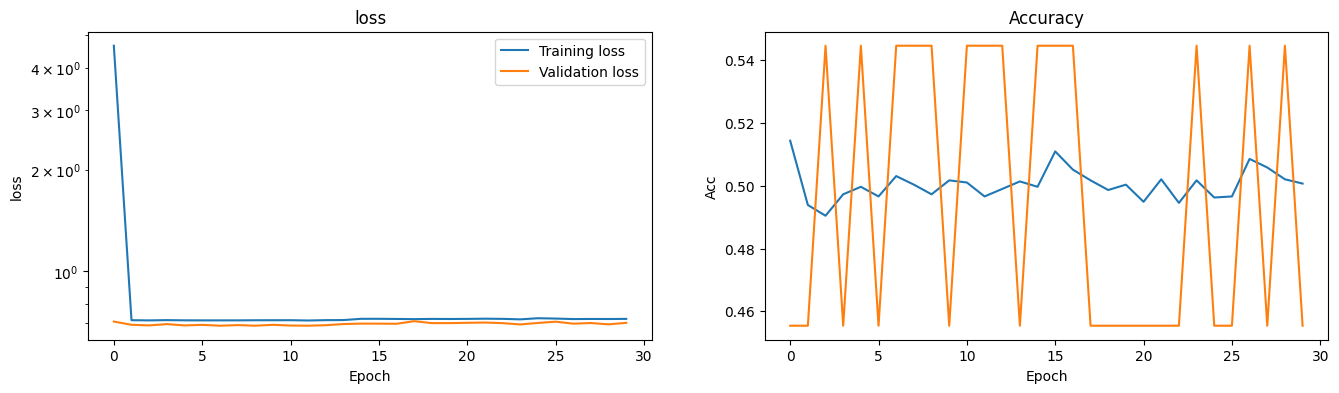

In [38]:
train_loss=lstm_model.history.history['loss']
val_loss=lstm_model.history.history['val_loss']
    
cat_acc=lstm_model.history.history['categorical_accuracy']
val_acc=lstm_model.history.history['val_categorical_accuracy']
        
pred = lstm_model.predict(X_all)
pred_val = lstm_model.predict(X_validation)
pred_train = lstm_model.predict(X_train)
pred_test = lstm_model.predict(X_test)

# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend